In [50]:
import re 
import numpy as np 
import pandas as pd 
from pprint import pprint 
import unicodedata  
# Importando a library Natural Language Toolkit - NLTK para tratamento de linguagem natural. 
import nltk 
nltk.download('wordnet') 
nltk.download('punkt')  
#Importando as stopwords 
from nltk.corpus import stopwords 
nltk.download('stopwords') 
language = 'portuguese'  
stopwords = stopwords.words(language) 
stopwords = list(set(stopwords))  
#Gensim 
import gensim 
import gensim.corpora as corpora 
from gensim.utils import simple_preprocess 
from gensim.models import CoherenceModel,Phrases
#Plotagem 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 
from wordcloud import WordCloud, STOPWORDS 
import logging 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)  

 


[nltk_data] Downloading package wordnet to /home/daviga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/daviga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/daviga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
caminho = 'data/BRANCA.csv'
dataframe = pd.read_csv(caminho)

colunas_selecionadas = ['ementa', 'ementaDetalhada','keywords']
dataframe = dataframe[colunas_selecionadas]



In [52]:
import re

# Convertendo para lista e garantindo que todos os elementos sejam strings
data = dataframe['ementa'].astype(str).tolist()

# Removendo novas linhas 
data = [re.sub(r'\s+', ' ', sent) for sent in data]

# Removendo distrações 
data = [re.sub(r"\'", "", sent) for sent in data]

In [53]:
def to_lowercase(words):
   new_words = []     
   for word in words: 
     new_word = word.lower()         
     new_words.append(new_word)     
   return new_words
 
data = to_lowercase(data)

In [54]:
#Aplicando função para remover os caracteres Non ASCII
def remove_non_ascii(words):
   """Remove non-ASCII characters from list of tokenized words"""
   new_words = []
   for word in words:
      new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
      new_words.append(new_word)
   return new_words

c = remove_non_ascii(data)

In [55]:
#Removendo pontuação e fazendo a tokeinização (para conseguir aplicar o modelo LDA)
def sent_to_words(sentences):
     for sentence in sentences:
         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations  
data_words = list(sent_to_words(data))  

In [56]:

stopwords = nltk.corpus.stopwords.words('portuguese') 
stopwords.append('requer')
stopwords.append('altera') 
stopwords.append('lei')
stopwords.append('artigo')
stopwords.append('realizacao')
stopwords.append('acrescenta')
stopwords.append('publica')
stopwords.append('ministra')
stopwords.append('ministerio')
stopwords.append('publica')
stopwords.append('nº')
stopwords.append('dispoe')
stopwords.append('outras')
stopwords.append('sobre')
stopwords.append('pl')
stopwords.append('requerimento')
stopwords.append('materia')
stopwords.append('retirada')
stopwords.append('pauta')
stopwords.append('aprovacao')
stopwords.append('municipio')
stopwords.append('municipios')
stopwords.append('arts')
stopwords.append('art')
stopwords.append('pedro')
stopwords.append('xxiv')
stopwords.append('mg')
stopwords.append('sp')
stopwords.append('go')
stopwords.append('dispor')
stopwords.append('parecer')
stopwords.append('relator')
stopwords.append('nominal')
stopwords.append('pp')
stopwords.append('dep')
stopwords.append('relatora')
stopwords.append('cezinha')
stopwords.append('plp')
stopwords.append('dani')
stopwords.append('cunha')
stopwords.append('psd')
stopwords.append('madureira')
stopwords.append('nominal')
stopwords.append('institui')
stopwords.append('setembro')
stopwords.append('dezembro')
stopwords.append('outubro')
stopwords.append('rs')
stopwords.append('sra_nisia')



In [57]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]
# Removendo Stop Words
data_words_nostops = remove_stopwords(data_words)


In [58]:
# Construa os modelos de bigramas e trigramas
bigram = Phrases(data_words_nostops, min_count=5, threshold=100) # Quanto maior o número, menos frases.
trigram = Phrases(bigram[data_words_nostops], threshold=100)  

# A maneira mais rápida de obter uma frase é acessar o objeto `Phrases` 
bigram_mod = bigram
trigram_mod = trigram

def make_bigrams(texts):
     return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
     return [trigram_mod[bigram_mod[doc]] for doc in texts]  
# Formando Bigrams 
data_words_bigrams = make_bigrams(data_words_nostops)

In [59]:
# Criando dicionário 
id2word = corpora.Dictionary(data_words_bigrams)  
# Criando corpus 
texts = data_words_bigrams  
# Frequencia do documento do termo 
corpus = [id2word.doc2bow(text) for text in texts]  
# visualizando 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [60]:
# Construindo LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
pprint(lda_model.print_topics()) 
doc_lda = lda_model[corpus]

[(0,
  '0.064*"dia" + 0.033*"termos_regimentais" + 0.025*"sessao_solene" + '
  '0.022*"sistema" + 0.020*"respeito" + 0.019*"geral" + 0.014*"agencia" + '
  '0.014*"cria" + 0.014*"homenagem" + 0.013*"requerer"'),
 (1,
  '0.055*"publico" + 0.054*"projeto" + 0.021*"pais" + 0.020*"fim" + '
  '0.019*"nao" + 0.015*"social" + 0.013*"incluir" + 0.012*"crimes" + '
  '0.012*"registro" + 0.012*"autista"'),
 (2,
  '0.064*"acerca_medidas" + 0.060*"estado" + 0.028*"ministro" + '
  '0.025*"amazonas" + 0.025*"garantir_qualidade" + 0.025*"regular_unidades" + '
  '0.025*"estrategias_adotadas" + 0.025*"adequada_funcionamento" + '
  '0.025*"ensino_infraestrutura" + 0.024*"sr"'),
 (3,
  '0.067*"educacao" + 0.043*"ensino" + 0.029*"inclusao" + 0.023*"maio" + '
  '0.022*"criacao" + 0.019*"programa" + 0.016*"sugere" + 0.016*"brasileiro" + '
  '0.013*"combate" + 0.013*"justica"'),
 (4,
  '0.028*"deste" + 0.026*"brasil" + 0.025*"uniao" + '
  '0.024*"juridicidade_tecnica" + 0.020*"junho" + 0.016*"anos" + '
  '0.01

In [61]:
# Calculando a perplexidade 
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Calculando o score de coerência 
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.39571417635452

Coherence Score:  0.44410031862996807


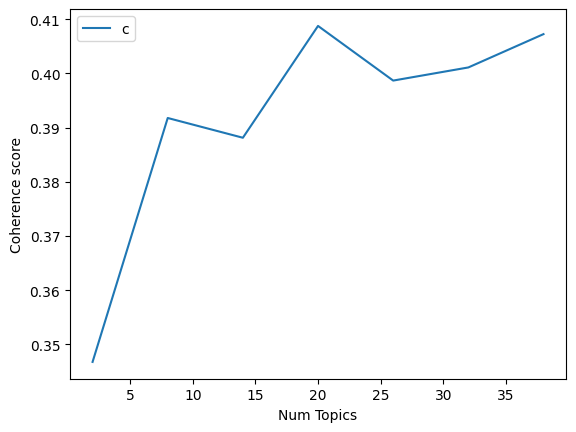

In [62]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# It may take a while to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico 
for m, cv in zip(x, coherence_values):
     print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3468
A quantidade de tópicos = 8  tem um valor de coerência de  0.3918
A quantidade de tópicos = 14  tem um valor de coerência de  0.3881
A quantidade de tópicos = 20  tem um valor de coerência de  0.4088
A quantidade de tópicos = 26  tem um valor de coerência de  0.3987
A quantidade de tópicos = 32  tem um valor de coerência de  0.4011
A quantidade de tópicos = 38  tem um valor de coerência de  0.4072


In [64]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico 
max_cv = max(zip(x, coherence_values), key=lambda item: item[1])
print("A quantidade de tópicos =", max_cv[0], " tem o maior valor de coerência de ", round(max_cv[1], 4))


# Encontrar a posição do valor máximo
max_coherence_value = max(coherence_values)
position = coherence_values.index(max_coherence_value)

print("A posição do maior valor de coerência é:", position)

A quantidade de tópicos = 20  tem o maior valor de coerência de  0.4088
A posição do maior valor de coerência é: 3


In [65]:
# Selecionando o modelo  e imprimindo os tópicos. 
optimal_model = model_list[6] 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(29,
  '0.021*"nacional" + 0.020*"seguranca" + 0.012*"inclusao" + '
  '0.011*"estabelece" + 0.010*"reajuste" + 0.010*"comissao" + 0.010*"nºs" + '
  '0.010*"empresas" + 0.009*"ensino" + 0.009*"melhoria" + 0.008*"aplicativos" '
  '+ 0.008*"valores" + 0.008*"diretrizes" + 0.007*"educacao" + 0.007*"medio"'),
 (5,
  '0.016*"educacao" + 0.011*"urgencia" + 0.011*"audiencia" + 0.010*"nacional" '
  '+ 0.009*"debater" + 0.009*"ensino" + 0.008*"fisica" + 0.008*"projeto" + '
  '0.007*"agosto" + 0.007*"saude" + 0.007*"violencia" + 0.007*"medidas" + '
  '0.006*"almeida" + 0.006*"federal" + 0.006*"infancia"'),
 (25,
  '0.030*"tramitacao" + 0.016*"mocao_aplauso" + 0.012*"federal" + 0.012*"pais" '
  '+ 0.012*"pessoa" + 0.011*"sob" + 0.010*"servicos" + 0.010*"novembro" + '
  '0.010*"constituicao" + 0.009*"civil" + 0.008*"contra" + 0.008*"brasileira" '
  '+ 0.007*"deficiencia" + 0.007*"proposta" + 0.007*"marco"'),
 (1,
  '0.016*"estado" + 0.013*"ministro" + 0.009*"administracao" + 0.008*"sc" + '
  '0.00

In [66]:

def format_topics_sentences(ldamodel, corpus, texts):
    # Saída inicial
    sent_topics = []

    # Obtém o tópico principal em cada documento
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        # Obtém o tópico dominante, contribuição em percentual e palavras-chave para cada documento
        topic_num, prop_topic = row[0]  # considera apenas o tópico dominante
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics.append({'Tópico dominante': int(topic_num), 'Percentual de Contribuição': round(prop_topic,4), 'Palavras Chave': topic_keywords})

    sent_topics_df = pd.DataFrame(sent_topics)

    # Adiciona o texto original no final da saída
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Transcription")], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Formatando
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Número do documento', 'Tópico dominante', 'Perc. de Contribuição do Tópico', 'Palavras Chave', 'Transcription']

# Mostre 
df_dominant_topic.head(10)

,Número do documento,Tópico dominante,Perc. de Contribuição do Tópico,Palavras Chave,Transcription
0,0,9,0.9536,"comissao, audiencia, debater, apresentar, fede...",garante ao acertador de qualquer tipo de jogo ...
1,1,21,0.8414,"decreto, janeiro, nacional, termos, projeto, a...",regulamenta o § 7º do art. 37 da constituição ...
2,2,30,0.6363,"legislativa, nacional, estado, comunitaria, fe...","altera dispositivos da lei nº 9.648, de 27 de ..."
3,3,25,0.4275,"tramitacao, mocao_aplauso, federal, pais, pess...","modifica a redação do art. 7º da lei nº 9.709,..."
4,4,29,0.7565,"nacional, seguranca, inclusao, estabelece, rea...",acrescenta ao art. 55 da lei nº 8.666 de 21 de...
5,5,16,0.4831,"comissao, boa, ensino, audiencia, constituicao...",concede desconto de 50% (cinqüenta por cento) ...
6,6,33,0.8918,"audiencia, debater, req, inclusao, futebol, re...",dispõe sobre a reintegração no emprego dos fun...
7,7,27,0.6105,"nacional, adesao_frente, parlamentar_mista, sa...","altera a lei nº 9.656, de 3 de junho de 1998, ..."
8,8,9,0.9487,"comissao, audiencia, debater, apresentar, fede...","revoga a lei complementar nº 110, de 29 de jun..."
9,9,33,0.8609,"audiencia, debater, req, inclusao, futebol, re...",dispõe sobre a obrigatoriedade de banheiros pú...


10


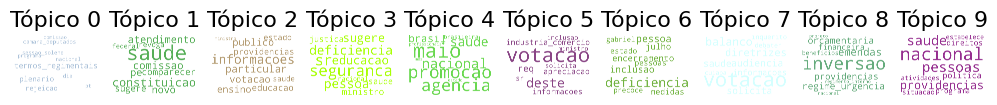

In [67]:
# Criando wordclouds
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=stopwords,
                background_color='white',
                width=2500,
                height=1800,
                max_words=30,
                colormap='tab10',
                color_func=lambda *args,**kwargs: cols[i],
                prefer_horizontal=1.0)
topics = optimal_model.show_topics(formatted=False)

# Limita o número de tópicos a mostrar ao número de tópicos que o modelo realmente produziu
num_topics = min(len(topics), 40)
print(num_topics)

fig, axes = plt.subplots(1, num_topics, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=600)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Tópico ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()